# <center>Wassmap: Wasserstein Isometric Mapping</center>

This notebook provides the main code to implement the method Wassmap from the paper "K. Hamm, N. Henscheid, and S. Kang, Wassmap: Wasserstein Isometric Mapping for Image Manifold Learning, arXiv: 2204.06645." The paper can be found here https://arxiv.org/pdf/2204.06645.pdf

At the end of this notebook, we supply the code to perform the experiments from the paper.

In [2]:
## Main instal statements. Should only be run once. If using Google Colab, you may need to change format to !yes | pip install...
!pip3 install -U --quiet https://github.com/PythonOT/POT/archive/master.zip 
!pip3 install -U --quiet pyDiffMap
!pip3 install -U --quiet numpy cython 
!pip3 install -U --quiet scikit-learn
!pip3 install -U --quiet torch
!pip3 install --quiet ipympl
!pip3 install -U --quiet tensorflow
!pip3 install -U networkx

     |████████████████████████████████| 2.0 MB 1.2 MB/s eta 0:00:01


In [3]:
## Import statements

import sklearn
import numpy as np
import ot
import ot.plot

# networkx is a graph library 
import networkx as nx

import time

from sklearn import manifold as man
from sklearn.decomposition import PCA
from pydiffmap import diffusion_map as dm

import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse

from torch import HalfStorage

# NOTE: RBFInterpolator needs scipy>=1.7.0
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator
#from scipy.interpolate import RBFInterpolator

import math

In [4]:
# Some global figure settings

%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
        'axes.titlesize': 32
         }

plt.rcParams.update(params)
 
font = {'family':'serif','weight':'normal','size':18}
plt.rc('font',**font)

np.set_printoptions(edgeitems=30, linewidth=100000,formatter=dict(float=lambda x: "%.3g" % x))

## Voxels vs. Pointclouds

There are two representations of images that are used in this notebook. ISOMAP considers an image as a "voxel array", i.e., as a matrix whose entries are the pixel intensity values, typically either between 0 and 1 or integers between 0 and 255 for greyscale images. Wassmap considers an image as a "pointcloud", i.e., as a set of coordinates (x,y,w) where (x,y) corresponds to the 2-d spatial location and w is the pixel intensity at that location. This is representing a dirac train of the form $$\sum w_{ij}\delta_{(x_i,y_j)}$$
where $(x_i,y_j)$ come from a prescribed meshgrid based on the voxel image size.

The following functions allow one to pass back and forth from one representation to another to be used in ISOMAP (and other dimensionality reduction methods) or Wassmap.

In [6]:
# Functions for voxel reps and pointcloud reps
# NOTE: classical Isomap is defined for voxelized images, not pointclouds.

def vox_to_pointcloud(voxarray,grid,eps=0):
    # Convert a voxel representation ('voxarray') to a (weighted) point cloud representation 
    # Assume that the input grid is in "ij meshgrid" format i.e. the grid has two layers, xx and yy, each size (nx)-by-(ny)
    # The voxel array will be unrolled via "column-major" order ("Fortran/Matlab" ordering)
    # Note that initially the number of voxels must equal the number of grid points - but 
    # zero voxels will be removed from the representation (i.e. no points with weight zero allowed)
    # if the optional parameter eps is passed, voxels with value less or equal to eps will be dropped
    # The returned array consists of (x,y,w) tuples i.e. X = [x1,y1,w1;x2,y2,w2;...;xP,yP,wP] where P 
    # is the number of nonzero points 
    xx,yy = np.squeeze(np.split(grid,2))
    X = np.vstack((xx.ravel(),yy.ravel())).T
    nX  = X.shape[0] # Number of points = number of rows
    nvi = voxarray.shape[0] # Number of voxel rows
    nvj = voxarray.shape[1] # Number of voxel cols 
    if nX != nvi*nvj: raise ValueError("Number of grid points must equal number of voxels!")
    X = np.concatenate((X,voxarray.T.reshape(nvi*nvj,1)),axis=1)
    return X[X[:,-1]>eps,:]

def pointcloud_to_vox(array,grid):
    # Converts a pointcloud representation to a voxel representation 
    # Assumes that the grid is in "ij meshgrid" format i.e. grid has two layers, xx and yy; each are size (nx+1)-by-(ny+1)
    # The grid points are assumed to define the corners of the voxels, so the 
    # voxel rep will be a single nx-by-ny array with entries equal to the average pointcloud weights
    # V_ij = \mean_k W_k if (x_k,y_k) is in voxel ij
    xx,yy = np.squeeze(np.split(grid,2))
    points = array[:,0:2]
    values = array[:,2]
    # One can use different interpolators here. NearestNDInterpolator uses nearest neighbor values to fill in missing
    # grid entries, but this results in a coarser image. LinearND is smoother.
#   interp = NearestNDInterpolator(points,values)
    interp = LinearNDInterpolator(points,values,fill_value=0.0)
    X = interp(xx,yy).T
    return X

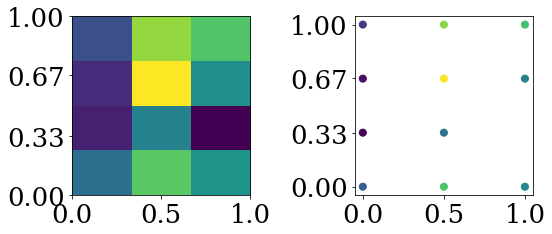

In [7]:
# Testing voxel-to-pointcloud conversion

# First, create voxel array
numx = 3
numy = 4

voxarray = np.random.rand(numy,numx)  # Note: number of rows = number of y points
# Set one of the elements to zero (to check zero weight handling)
voxarray[1,2] = 0 

# Create a pointcloud grid for vox-to-PC conversion
nxg = numx
nyg = numy
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
# Convert voxel array to pointcloud
X = vox_to_pointcloud(voxarray,grid)
# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)

ax1.imshow(voxarray,origin='lower',extent=(0,1,0,1))
ax1.set_xticks(np.round(x,2))
ax1.set_yticks(np.round(y,2))
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
ax2.set_xticks(np.round(x,2))
ax2.set_yticks(np.round(y,2))
fig1.tight_layout()

(0.0, 1.0)

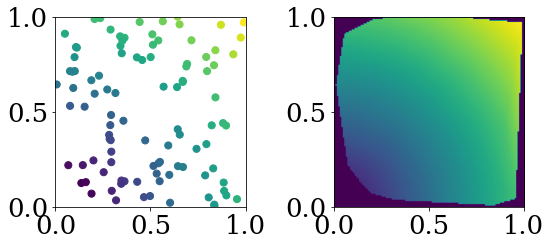

In [8]:
# Testing pointcloud-to-voxel conversion

# Generate a pointcloud by selecting random points
nPC = 100
points = np.random.rand(nPC,2)
values = np.hypot(points[:,0],points[:,1])
PCarray = np.hstack((points,values[:,np.newaxis]))
# Create a grid for pointcloud-to-voxel conversion
nxg = 129
nyg = 129
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
Y = pointcloud_to_vox(PCarray,grid)

fig2,(ax3,ax4) = plt.subplots(1,2)
fig2.tight_layout()
ax3.scatter(PCarray[:,0],PCarray[:,1],s=50,c=PCarray[:,2])
ax4.imshow(Y,origin='lower',extent=[0,1,0,1])
ax3.set_aspect(1)
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)

## Synthetic Image Generation
The functions below generate pointcloud-format images corresponding to indicator functions of certain domains in $\mathbb{R}^2$. One can generate rectangles, triangles, circles, and ellipses. Standard usage of these functions may be found in the Experiments later in the notebook.

In [12]:
def generate_rectangle(side0, side1, initial_point=[0,0], samples=100):
    # Generates a rectangle in point cloud format
    x = np.linspace(initial_point[0], initial_point[0]+side0, num=samples)
    y = np.linspace(initial_point[1], initial_point[1]+side1, num=samples)
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

def in_triangle(endpoint1,endpoint2,endpoint3,point):
    # Indicator function of a triangle 
    # Returns 1 (True) if point is in the triangle, zero (False) else
    c1 = (endpoint2[0]-endpoint1[0])*(point[1]-endpoint1[1]) - (endpoint2[1]-endpoint1[1])*(point[0]-endpoint1[0])
    c2 = (endpoint3[0]-endpoint2[0])*(point[1]-endpoint2[1]) - (endpoint3[1]-endpoint2[1])*(point[0]-endpoint2[0])
    c3 = (endpoint1[0]-endpoint3[0])*(point[1]-endpoint3[1]) - (endpoint1[1]-endpoint3[1])*(point[0]-endpoint3[0])

    if (c1<0 and c2<0 and c3<0) or (c1>0 and c2>0 and c3>0):
        return True
    else:
        return False    

def generate_triangle(endpoint1, endpoint2, endpoint3, samples=100):
    # Generates a triangle in point cloud format
    x = np.linspace(min(endpoint1[0],endpoint2[0],endpoint3[0]), max(endpoint1[0],endpoint2[0],endpoint3[0]), num=samples)
    y = np.linspace(min(endpoint1[1],endpoint2[1],endpoint3[1]), max(endpoint1[1],endpoint2[1],endpoint3[1]), num=samples)
    xy_0 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    xy = []
    for point in xy_0:
        if in_triangle(endpoint1,endpoint2,endpoint3,point):
            xy.append(point)
    return np.array(xy)

def in_circle(center, radius, point):
    # Indicator function of a circle
    # Returns 1 (True) if point is in the circle, zero (False) else
    if (point[1]-center[1])**2+(point[0]-center[0])**2<=radius**2:
        return True
    else:
        return False

def generate_circle(center, radius, samples=100):
    # Generates a circle in pointcloud format
    x = np.linspace(center[0]-radius, center[0]+radius, num=samples)
    y = np.linspace(center[1]-radius, center[1]+radius, num=samples)
    xy_0 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    xy = []
    for point in xy_0:
        if in_circle(center,radius,point):
            xy.append(point)
    return np.array(xy)

def generate_ellipse(center, axis_x, axis_y,samples = 100):
    # Requires running of transformation cell below
    # Generates an ellipse in pointcloud format by dilating a circle
    circle = generate_circle([0,0],1,samples)
    ellipse = dilation(circle,[axis_x, axis_y])
    ellipse = translation(ellipse,center)
    return np.array(ellipse)

## Transformations of Images
Here we implement various operations on an input image: rotation, translation, and dilation. Note that dilations are along the coordinate axes and of the form $f(\text{diag}(\theta_0,\theta_1)x)$, but if one wants to do generic dilation one can rotate and then dilate an image. These functions should work on both voxel and pointcloud images.

In [13]:
def rotation(object, radian_degree):
    # Rotates an object counterclockwise by radian_degree
    A = [[math.cos(radian_degree), -math.sin(radian_degree)],[math.sin(radian_degree), math.cos(radian_degree)]]
    image = []
    for index,point in enumerate(object):
        image.append(np.matmul(A,point))
    return np.array(image)

def translation(object, translate_direction):
    # translate_direction is a list or ndarray of the form [t, s]
    # function translates an object located at [x,y] to [x+t, y+s]
    object_array = np.array(object)
    direction_array = np.array(translate_direction)
    image = [x + direction_array for x in object_array]
    return np.array(image)

def dilation(object, parameter):
    # Dilates an object by multiplying it by a diagonal matrix
    # parameter is a list or ndarray of size 2
    A = [[parameter[0], 0],[0, parameter[1]]]
    image = []
    for index,point in enumerate(object):
        image.append(np.matmul(A,point))
    return np.array(image)

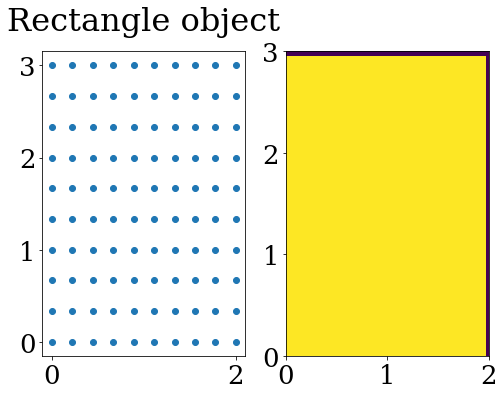

In [18]:
## Example usage: generate a rectangle object in both voxel and pointcloud representation

W = 2
H = 3
rect = generate_rectangle(W,H, samples=10)
nxg = 64
nyg = 64
dx = W/nxg
dy = H/nyg

x = np.linspace(0,2+dx,nxg+1)
y = np.linspace(0,3+dy,nyg+1)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
rect_pc    = np.concatenate((rect,np.ones((100,1))),axis=1)
rect_voxel = pointcloud_to_vox(rect_pc,grid)
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.scatter(rect[:,0],rect[:,1])
ax1.set_aspect(1)
ax1.set_title('Rectangle object',y=1.05)
ax2.imshow(rect_voxel,origin='lower',extent=[0,2,0,3])
plt.show()

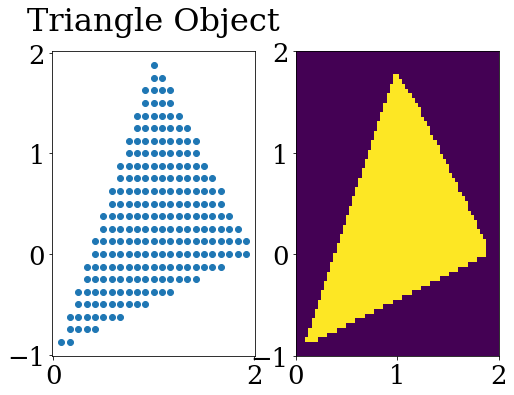

In [22]:
## Example usage: generate a triangle in voxel and pointcloud representation

tri = generate_triangle([0,-1],[1,2],[2,0], samples=25)

nxg = 64
nyg = 64
dx = 2/nxg
dy = 3/nyg

x = np.linspace(0,2+dx,nxg+1)
y = np.linspace(-1,2+dy,nyg+1)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
tri_pc    = np.concatenate((tri,np.ones((tri.shape[0],1))),axis=1)
tri_voxel = pointcloud_to_vox(tri_pc,grid)

fig,(ax1,ax2) = plt.subplots(1,2)
ax1.scatter(tri[:,0],tri[:,1])
ax1.set_aspect('equal')
ax1.set_title('Triangle Object',y=1.05)
ax2.imshow(tri_voxel,origin='lower',extent=[0,2,-1,2])
plt.show()

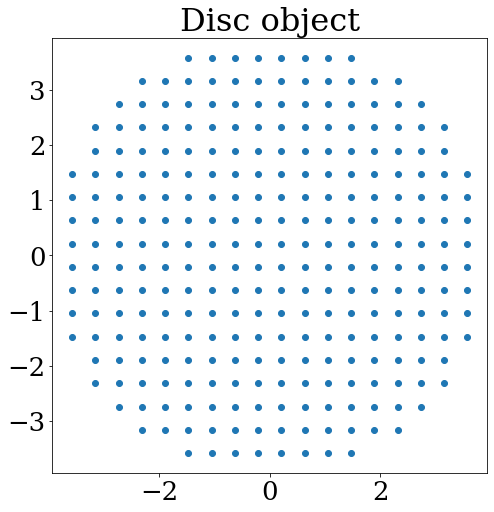

In [25]:
## Example usage: generate a circle of radius 4 centered at the origin

circ = generate_circle([0,0],4,samples=20)

fig,ax = plt.subplots()
ax.scatter(circ[:,0],circ[:,1])
ax.set_aspect('equal')
ax.set_title('Disc object')
plt.show()

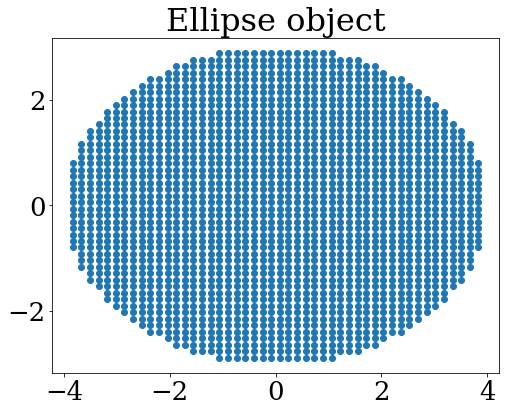

In [30]:
## Example usage: generate an ellipse
ellip = generate_ellipse([0,0],4,3,samples=50)

fig,ax = plt.subplots()
ax.scatter(ellip[:,0],ellip[:,1])
ax.set_aspect('equal')
ax.set_title('Ellipse object')
plt.show()

# <center>Main Wassmap Functions</center>
The following functions are the main functions to run Wassmap on pointcloud representations of images. Note that sklearn has an implementation of MDS, but we use our own version here for consistent results. Some of the parameter choices of sklearn's implementation can cause irregularities in the embeddings

In [52]:
def uniform_Wass_squared(U, V,Itermax=100000):
    # Assumes that U and V are pointclouds i.e. U = [x1,y1,w1;...;xp,yp,wp] etc
    Upts = np.ascontiguousarray(U[:,0:2])
    Vpts = np.ascontiguousarray(V[:,0:2])
    Uwts = np.ascontiguousarray(U[:,2])
    Vwts = np.ascontiguousarray(V[:,2])
    Uwts = Uwts/np.sum(Uwts)
    Vwts = Vwts/np.sum(Vwts)
    M = ot.dist(Upts, Vpts)  # Compute euclidean distance on the pointcloud points
    W = ot.emd2(Uwts,Vwts, M,numItermax=Itermax) # Compute exact W_2 distances
    ## ot.emd2 is the exact linear program function to compute W_2 distances exactly. This is slow.
    ## The user can substitute other W_2 distance approximations such as ot.sinkhorn or many others
    ## Example in the following lines
    #reg = 0.5
    #W = ot.sinkhorn2(Uwts,Vwts, M, reg)
    return W

def Wasserstein_Matrix(image_list,squared=True):
    """
    The function compute the (squared if squared=True) Wasserstein Distance Matrix between N images
    image_list: python list of pointcloud representations 
    """
    N = len(image_list) #number of images
    distance = np.zeros((N,N)) #initialize the distance matrix

    #cost = ot.dist(supp, supp) #should be a MXM array
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = uniform_Wass_squared(image_list[i], image_list[j])
            else:
                distance[i,j] = uniform_Wass_squared(image_list[i], image_list[j])**.5
    distance += distance.T
    return distance

def Euclidean_Matrix(image_tensor,squared=True):
    """
    The function compute the (squared if squared=True) Euclidean Distance Matrix between N 2D images
    image_tensor: Should be a Mx2xN array, where M is the number of pixels.
    """
    N = image_tensor.shape[-1] #number of rows 
    distance = np.zeros((N,N)) #initialize the distance matrix
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = la.norm(image_tensor[:,:,i]-image_tensor[:,:,j])**2
            else:
                distance[i,j] = la.norm(image_tensor[:,:,i]-image_tensor[:,:,j])
    distance += distance.T
    return distance

def Geodesic_Matrix(image_tensor,eps,squared=True):
    """
    Computes the Geodesic distance matrix for a set of N images 
    image_tensor is Mx2xN 
    """
    Euc_distance = Euclidean_Matrix(image_tensor,squared=False)
    Adj_matrix = np.copy(Euc_distance)
    Adj_matrix[Adj_matrix<eps] = 0 
    Euc_distance[Euc_distance<eps] = np.Inf
    G = nx.from_numpy_matrix(Adj_matrix)
    geo_matrix = shortest_path(Euc_distance, directed=False, return_predecessors=False)
    if(squared==True):
        geo_matrix = np.square(geo_matrix)
    return geo_matrix,G

def MDS(distance_matrix, num_components=2, squared=False):
    """
    Computes non-metric (classical) Multidimensional Scaling (MDS)
    Input should be an NxN distance matrix
    The Boolean squared indicates if the distance matrix passed to the function has already
    been squared entrywise (True) or not (False)
    num_components corresponds to the embedding dimension, which is defaulted to 2
    """
    N = distance_matrix.shape[0]
    H = np.eye(N)-1/N*np.ones((N,N))
    if squared==False:
        B = -.5*H@(distance_matrix**2)@H
    else:
        B = -.5*H@distance_matrix@H
    U,S,VT = la.svd(B)
    embedding = U[:,:num_components]@np.diag(S[:num_components]**.5)
    return embedding

# <center>Experiments for paper</center>
Here we reproduce the experiments that appear in the first version of the paper.

## Experiment 1: Translation of overlapping images
Here we generate the indicator of a circle and translation on a regular grid on $[-1,1]^2$. The figures below correspond to Figure 1 in the paper.

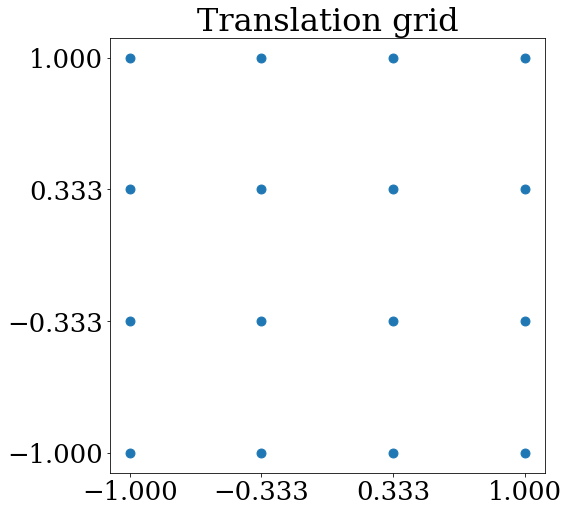

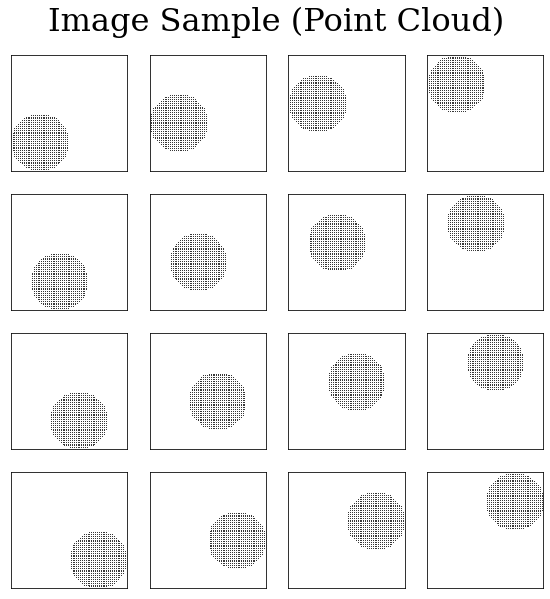

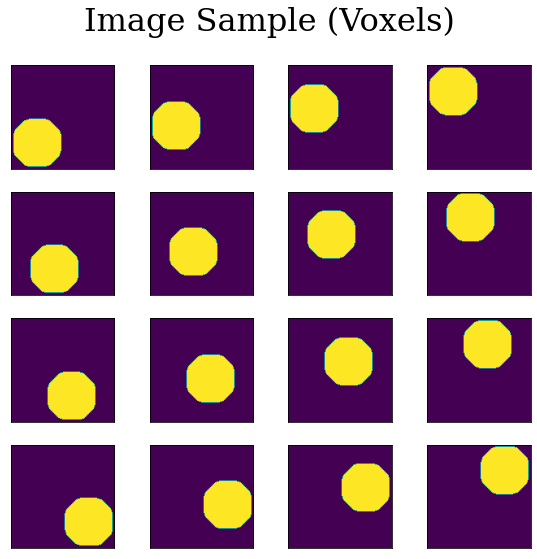

In [36]:
##Circle translate test 1:OVERLAPPING IMAGES::Image generation and setup
# NOTE: In this test, the translation grid is such that the resulting synthetic 
# images will overlap.  Thus, Isomap is at least well-defined (i.e. there are meaningful geodesics)

# Generate circle
# num_samplepoints is the number of points on the grid in both the x and y directions, so the generate_circle
# function builds a meshgrid of size num_samplepoints x num_samplepoints
num_samplepoints = 32
circ = generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set
num_translates = 4
num_samp = num_translates**2
x = np.linspace(-1,1,num=num_translates)
y = np.linspace(-1,1,num=num_translates)
xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
xx = np.reshape(xx,(num_translates**2,1))
yy = np.reshape(yy,(num_translates**2,1))
translates = np.zeros((num_translates**2,2))
for i in range(len(xx)):
    translates[i,0] = xx[i]
    translates[i,1] = yy[i]
    
# Plot the translation set
fig1,ax1 = plt.subplots()
ax1.scatter(translates[:,0],translates[:,1],s=80)
ax1.set_aspect('equal')
ax1.set_title('Translation grid')
ax1.set_xticks(x)
ax1.set_yticks(y)

# Generate translation images and image tensor
trans_images = []
for i in range(num_translates**2):
    img = np.concatenate((translation(circ,[translates[i,0],translates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    trans_images.append(img)

# Generate voxel images (for ISOMAP)
nvox = 128
nxg = nvox
nyg = nvox

xg = np.linspace(-2,2,nxg)
yg = np.linspace(-2,2,nyg)
xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
grid = np.stack((xxg,yyg))
trans_images_vox = np.zeros((nvox,nvox,num_translates**2))
for i in range(num_translates**2):
    pc = trans_images[i]
    trans_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)

fig2,transaxes = plt.subplots(num_translates,num_translates)

xtick = np.linspace(-2,2,5)
ytick = xtick

idx = 0
for i in range(num_translates): 
    for j in range(num_translates):
        idx = i + num_translates*j
        xxplt = trans_images[idx][:,0]
        yyplt = trans_images[idx][:,1]
        transaxes[i,j].scatter(xxplt,yyplt,s=1,linewidths=0,c='#000000')
        transaxes[i,j].set_xlim([-2,2])
        transaxes[i,j].set_ylim([-2,2])
        transaxes[i,j].set_aspect('equal')
        transaxes[i,j].set_xticks([])
        transaxes[i,j].set_yticks([])
fig2.tight_layout()
fig2.suptitle('Image Sample (Point Cloud)',y=1.05,fontsize=32)

# Voxel image figure
fig3,transaxes_vox = plt.subplots(num_translates,num_translates)
idx = 0
for i in range(num_translates): 
    for j in range(num_translates):
        idx = i + num_translates*j
        transaxes_vox[i,j].imshow(trans_images_vox[:,:,idx],origin='lower',extent=(-1.5,1.5,-1.5,1.5))
        transaxes_vox[i,j].set_xticks([])
        transaxes_vox[i,j].set_yticks([])
fig3.suptitle('Image Sample (Voxels)',fontsize=32)
fig3.tight_layout()
plt.show()

Computed Wasserstein distance matrix (N = 16) in 10.5924 seconds


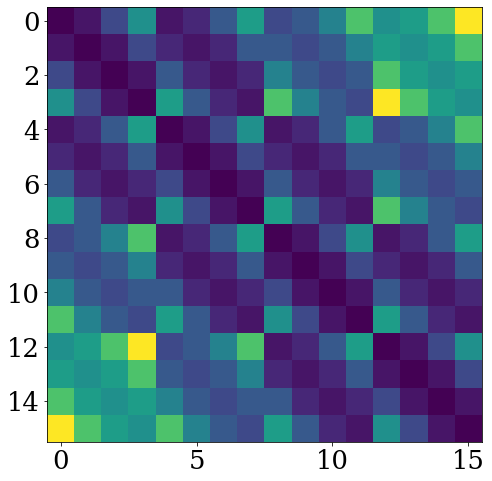

In [53]:
## Circle translation test :: Compute Wasserstein square distance matrix
tic = time.perf_counter()
Wass_distance_trans = Wasserstein_Matrix(trans_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance_trans)
plt.show()

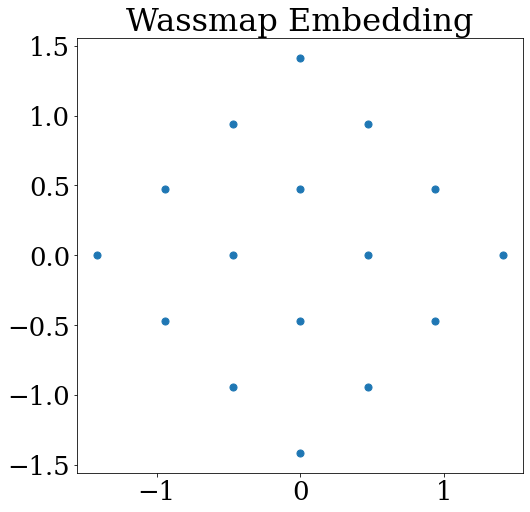

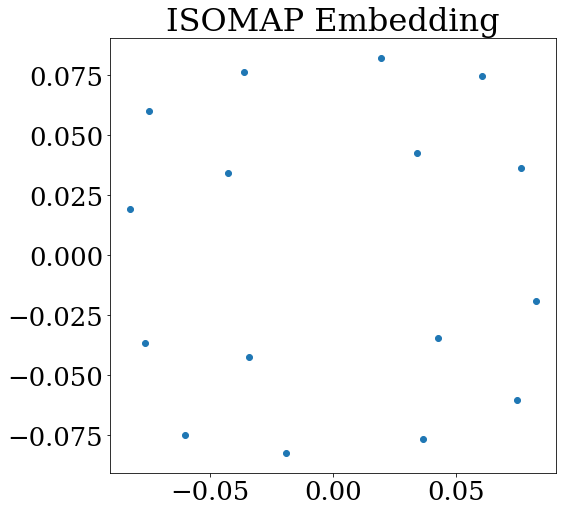

In [55]:
# Wassmap Embedding: MDS on Wass squared matrix
WassEmbedding_trans = MDS(Wass_distance_trans,squared=True)
fig, ax1 = plt.subplots()
scatter_x = WassEmbedding_trans[:,0]
scatter_y = WassEmbedding_trans[:,1]
ax1.scatter(scatter_x,scatter_y,s=50)
ax1.set_title('Wassmap Embedding')
plt.show()

# ISOMAP Embedding: Here we use the Isomap function of manifold for consistency. Note that ISOMAP is 
# very sensitive to the parameter choice
temp = np.reshape(trans_images_vox.T,[trans_images_vox.shape[-1],trans_images_vox.shape[0]**2])
trans_embedded_isomap = man.Isomap(n_neighbors=7,n_components=2,metric='euclidean').fit_transform(temp)

fig, ax = plt.subplots()
scatter_x = trans_embedded_isomap[:,0]
scatter_y = trans_embedded_isomap[:,1]
ax.scatter(scatter_x, scatter_y)
ax.set_title("ISOMAP Embedding")
plt.show()

## Experiment 2: Nonconvex translation grid
Here we generate the indicator of a circle and translation on a disjoint regular grid, one part on $[-2,1]\times [-1,1]$ and the second part on $[1,2]\times[-1,1]$. The figures below correspond to Figure 2 in the paper.

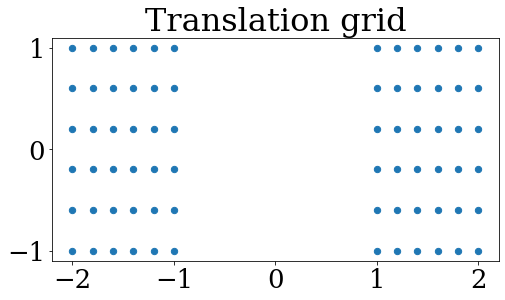

In [59]:
##Circle translate test 2::Image generation and setup
## Translation set is a grid in 2 disjoint rectangles: [-2,-1]x[-1,1] union [1,2]x[-1,1]

# Generate circle
num_samplepoints = 32
circ = generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set 1
num_translates = 6
num_samp = num_translates**2
x = np.linspace(-2,-1,num=num_translates)
y = np.linspace(-1,1,num=num_translates)
np.random.shuffle(x) # Shuffle to make sure the order of the images doesn't matter
np.random.shuffle(y) 
xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
xx = np.reshape(xx,(num_translates**2,1))
yy = np.reshape(yy,(num_translates**2,1))
translates1 = np.zeros((num_translates**2,2))
for i in range(len(xx)):
    translates1[i,0] = xx[i]
    translates1[i,1] = yy[i]
    
# Generate translation set 2
num_translates = 6
num_samp = num_translates**2
x = np.linspace(1,2,num=num_translates)
y = np.linspace(-1,1,num=num_translates)
np.random.shuffle(x) # Shuffle to make sure the order of the images doesn't matter
np.random.shuffle(y) 
xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
xx = np.reshape(xx,(num_translates**2,1))
yy = np.reshape(yy,(num_translates**2,1))
translates2 = np.zeros((num_translates**2,2))
for i in range(len(xx)):
    translates2[i,0] = xx[i]
    translates2[i,1] = yy[i]
    
translates = np.vstack((translates1,translates2))

# Plot the translation set 
fig1,ax1 = plt.subplots()
ax1.scatter(translates[:,0],translates[:,1],s=40)
ax1.set_aspect('equal')
ax1.set_title('Translation grid')
plt.show()

# Generate translation images and image tensor
trans_images = []
for i in range(translates.shape[0]):
    img = np.concatenate((translation(circ,[translates[i,0],translates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    trans_images.append(img)

# Generate voxel images (for ISOMAP)
nvox = 128
nxg = nvox
nyg = nvox

xg = np.linspace(-20,20,nxg)
yg = np.linspace(-6,6,nyg)
xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
grid = np.stack((xxg,yyg))
trans_images_vox = np.zeros((nvox,nvox,len(trans_images)))
for i in range(len(trans_images)):
    pc = trans_images[i]
    trans_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)
    
## Images not plotted here

Computed Wasserstein distance matrix (N = 36) in 242.1266 seconds


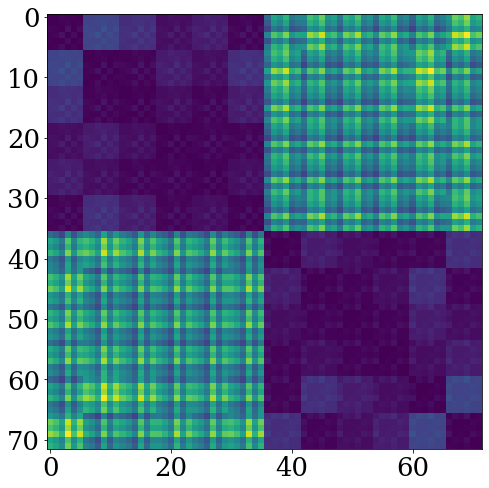

In [60]:
## Circle translation test 2:: Compute Wasserstein square distance matrix
tic = time.perf_counter()
Wass_distance = Wasserstein_Matrix(trans_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

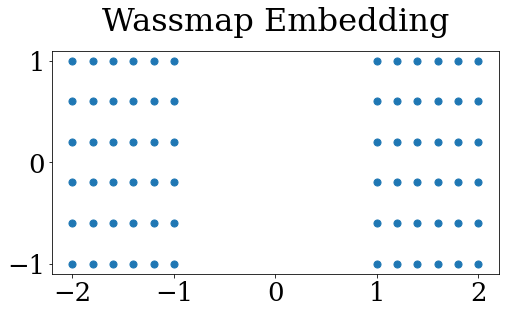

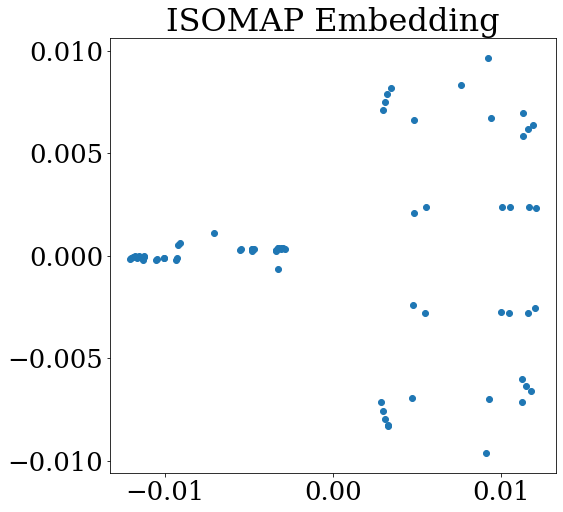

In [88]:
# Wassmap Embedding: MDS on Wass squared matrix
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax1 = plt.subplots()
scatter_x = WassEmbedding[:,0]
scatter_y = WassEmbedding[:,1]
ax1.scatter(scatter_x,scatter_y,s=50)
ax1.set_aspect("equal")
ax1.set_title('Wassmap Embedding',pad=20)
plt.show()

# ISOMAP Embedding
temp = np.reshape(trans_images_vox.T,[trans_images_vox.shape[-1],trans_images_vox.shape[0]**2])
trans_embedded_isomap = man.Isomap(n_neighbors = 50,n_components=2,metric='euclidean').fit_transform(temp)
fig, ax = plt.subplots()
scatter_x = trans_embedded_isomap[:,0]
scatter_y = trans_embedded_isomap[:,1]
ax.scatter(scatter_x, scatter_y)
ax.set_title("ISOMAP Embedding")
plt.show()

## Experiment 3: Dilation of a circle
Here we generate the indicator of an origin-centered circle and dilate it according to dilation parameters on a grid $[0.5,2]\times[0.5,4]$. The figures below correspond to Figure 3 in the paper.

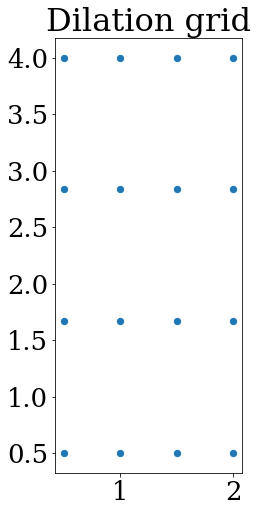

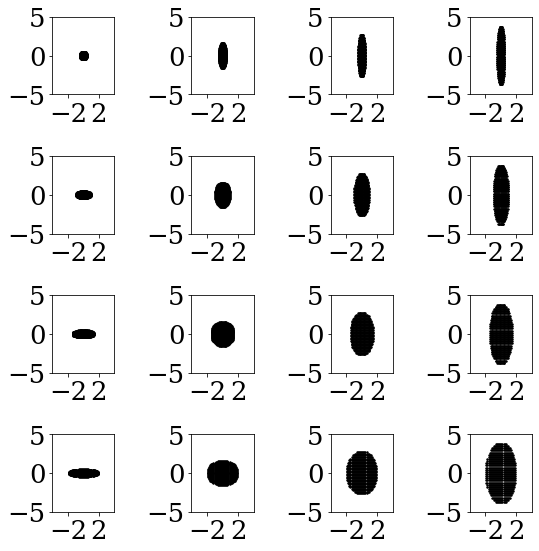

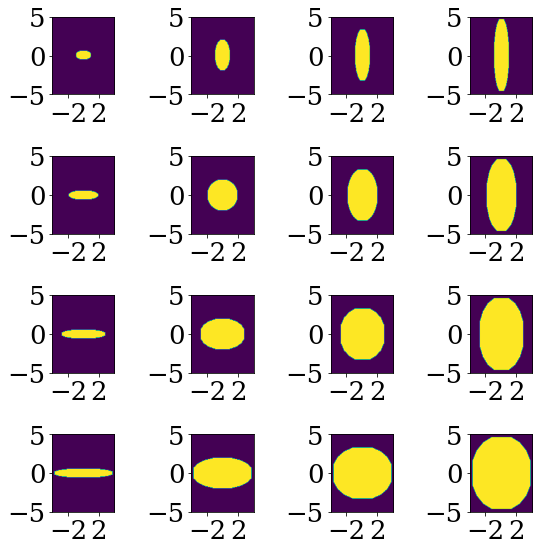

In [125]:
## Circle dilation test :: Indicator function of the unit disk dilated along the coordinate axes with dilation parameters
## taken from the grid [0.5,2]x[0.5,4]

# Generate circle
num_samplepoints = 30
radius = 1
circ = generate_circle([0,0],radius,samples=num_samplepoints)

# Generate dilation set
num_dilates = 4
x = np.linspace(.5,2,num=num_dilates)
y = np.linspace(.5,4,num=num_dilates)
xx,yy = np.meshgrid(x,y) #num_dilates x num_dilates matrices; each xx,yy entry is a dilation vector
xx = np.reshape(xx,(num_dilates**2,1))
yy = np.reshape(yy,(num_dilates**2,1))
dilates = np.zeros((num_dilates**2,2))
for i in range(len(xx)):
    dilates[i,0] = xx[i]
    dilates[i,1] = yy[i]

# Plot the dilation set 
fig1,ax1 = plt.subplots()
ax1.scatter(dilates[:,0],dilates[:,1],s=40)
ax1.set_aspect('equal')
ax1.set_title('Dilation grid')

# Generate dilation images and image tensor
dil_images = []
for i in range(num_dilates**2):
    img = np.concatenate((dilation(circ,[dilates[i,0],dilates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    dil_images.append(img)

# Generate voxel images (for ISOMAP)
nvox = 128
nxg = nvox
nyg = nvox

xg = np.linspace(-2,2,nxg)
yg = np.linspace(-4,4,nyg)
xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
grid = np.stack((xxg,yyg))
dil_images_vox = np.zeros((nvox,nvox,num_dilates**2))
for i in range(num_dilates**2):
    pc = dil_images[i]
    dil_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)

# Display pointcloud images
fig2,dilaxes = plt.subplots(num_dilates,num_dilates)
fig2.tight_layout()

xticks = np.linspace(-4,4,5)
yticks = np.linspace(-5,5,5)

idx = 0
for i in range(num_dilates): 
    for j in range(num_dilates):
        idx = i + num_dilates*j
        xxplt = dil_images[idx][:,0]
        yyplt = dil_images[idx][:,1]
        dilaxes[i,j].scatter(xxplt,yyplt,s=2,c='#000000')
        dilaxes[i,j].set_xlim([-4,4])
        dilaxes[i,j].set_ylim([-5,5])
        dilaxes[i,j].set_aspect('equal')
        dilaxes[i,j].set_xticks([-2,2])

# Display voxel images
fig3,dilaxes_vox = plt.subplots(num_dilates,num_dilates)
fig3.tight_layout()

idx = 0
for i in range(num_dilates): 
    for j in range(num_dilates):
        idx = i + num_dilates*j
        dilaxes_vox[i,j].imshow(dil_images_vox[:,:,idx],origin='lower',extent = (-4,4,-5,5))
        dilaxes_vox[i,j].set_xticks([-2,2])
plt.show()

In [ ]:
# CircleCompute Wasserstein square distance matrix
squared = True
Wass_distance = Wasserstein_Matrix(dil_images,squared=squared)

# Compute and display Wassmap embedding 
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=squared)
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(Wass_distance)
ax2.set_title("Wassmap Embedding of Dilation Images",pad=20)
ax2.scatter(WassEmbedding[:,0],WassEmbedding[:,1])
#plt.savefig('figures/DilationWassmapEmbedding.pdf')
plt.show()

## Note here that the 2nd moment of mu_0 (initial circle) is sqrt(pi)/2, which is the scaling factor appearing in
## the Wassmap embedding

Computed Wasserstein distance matrix (N = 36) in 6.0777 seconds


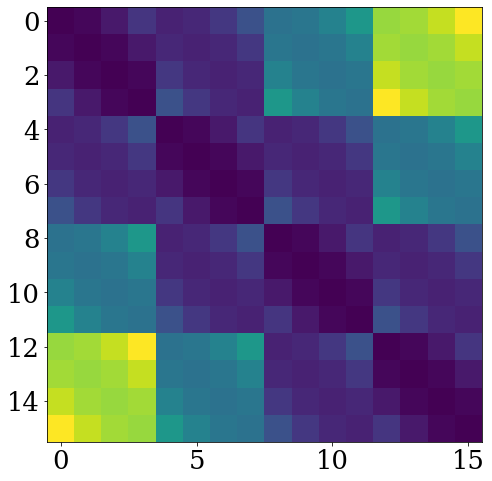

In [126]:
## Circle dilation test 2:: Compute Wasserstein square distance matrix
tic = time.perf_counter()
Wass_distance = Wasserstein_Matrix(dil_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

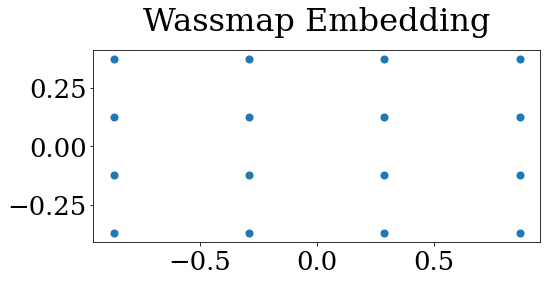

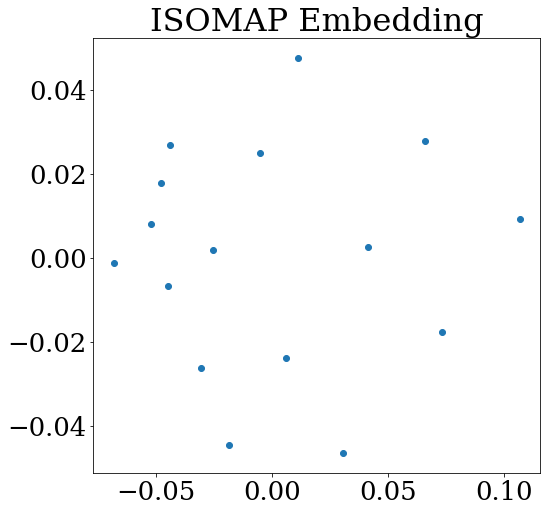

In [129]:
# Wassmap Embedding: MDS on Wass squared matrix
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax1 = plt.subplots()
scatter_x = WassEmbedding[:,0]
scatter_y = WassEmbedding[:,1]
ax1.scatter(scatter_x,scatter_y,s=50)
ax1.set_aspect("equal")
ax1.set_title('Wassmap Embedding',pad=20)
plt.show()

# ISOMAP Embedding
temp = np.reshape(dil_images_vox.T,[dil_images_vox.shape[-1],dil_images_vox.shape[0]**2])
dil_embedded_isomap = man.Isomap(n_neighbors=14,n_components=2,metric='euclidean',).fit_transform(temp)
fig, ax = plt.subplots()
scatter_x = dil_embedded_isomap[:,0]
scatter_y = dil_embedded_isomap[:,1]
ax.scatter(scatter_x, scatter_y)
ax.set_title("ISOMAP Embedding")
plt.show()

## Experiment 4: Rotation of origin-centered ellipse
Here we generate the indicator of an origin-centered ellipse and rotation at uniformly spaced angles on the circle. The figures below correspond to Figure 4 in the paper.

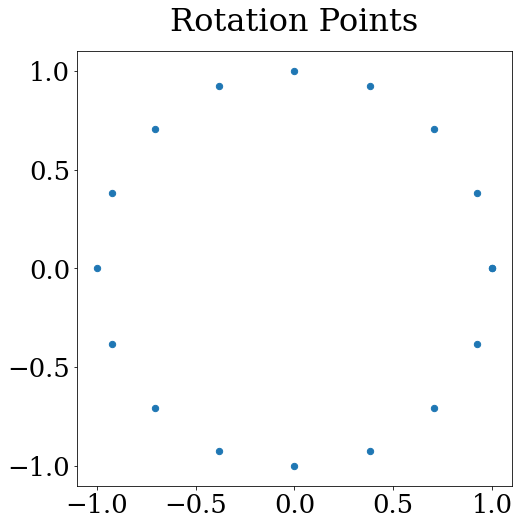

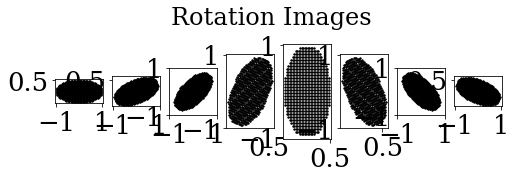

In [103]:
##Ellipse rotation test::Image generation and setup

# Generate ellipse
num_samplepoints = 32
ellipse = generate_ellipse([0,0], 1, .5, samples = num_samplepoints)

# Generate rotation set
num_rotations = 17
theta = np.linspace(0,2*np.pi,num=num_rotations)
x = np.cos(theta)
y = np.sin(theta)
rotates = np.zeros((num_rotations,2))
for i in range(len(x)):
    rotates[i,0] = x[i]
    rotates[i,1] = y[i]
np.random.shuffle(rotates)
    

# Plot the rotation set 
fig1,ax1 = plt.subplots()
ax1.scatter(rotates[:,0],rotates[:,1],s=40)
ax1.set_aspect('equal')
ax1.set_title('Rotation Points',pad=20)
plt.show()

# Generate rotation pointcloud representations
rot_images = []
for i in range(rotates.shape[0]):
    img = np.concatenate((rotation(ellipse,theta[i]),np.ones((ellipse.shape[0],1))/ellipse.shape[0]),axis=1)
    rot_images.append(img)
    
# Generate rotation image tensor for display purposes
rot_images2 = np.zeros((ellipse.shape[0],ellipse.shape[1],num_rotations))
for i in range(num_rotations):
    rot_images2[:,:,i] = rotation(ellipse,theta[i])
    
fig2,ax2 = plt.subplots(1,int(num_rotations/2))
for i in range(int(num_rotations/2)): 
    #for j in range(int(num_rotations/2)):
#         xxplt = rot_images[:,0,i+num_rotations*j]
#         yyplt = rot_images[:,1,i+num_rotations*j]
        xxplt = rot_images2[:,0,i]
        yyplt = rot_images2[:,1,i]
        ax2[i].scatter(xxplt,yyplt,s=2,c='#000000')
        ax2[i].set_aspect('equal')  
        if max(xxplt)<.6:
            ax2[i].set_xticks([round(2*max(xxplt))/2])
        else:
            ax2[i].set_xticks([round(2*min(xxplt))/2,round(2*max(xxplt))/2])
        if max(yyplt)<.6:
            ax2[i].set_yticks([round(2*max(yyplt))/2])
        else:
            ax2[i].set_yticks([round(2*min(yyplt))/2,round(2*max(yyplt))/2])
fig2.suptitle("Rotation Images",fontsize = 24,y=.65)
plt.show()

# Generate voxel images (for ISOMAP)
nvox = 128
nxg = nvox
nyg = nvox

xg = np.linspace(-6,6,nxg)
yg = np.linspace(-6,6,nyg)
xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
grid = np.stack((xxg,yyg))
rot_images_vox = np.zeros((nvox,nvox,len(rot_images)))
for i in range(len(rot_images)):
    pc = rot_images[i]
    rot_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)

Computed Wasserstein distance matrix (N = 36) in 9.7408 seconds


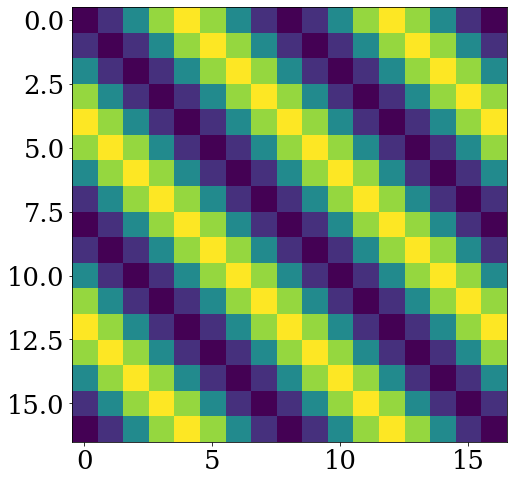

In [104]:
## Ellipse rotation test :: Compute Wasserstein square distance matrix
tic = time.perf_counter()
Wass_distance = Wasserstein_Matrix(rot_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

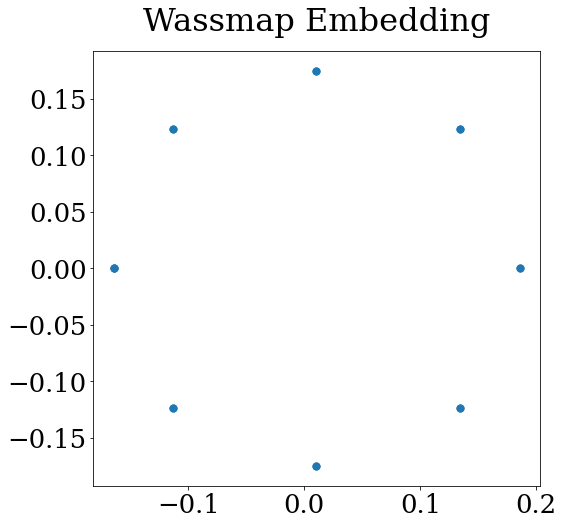

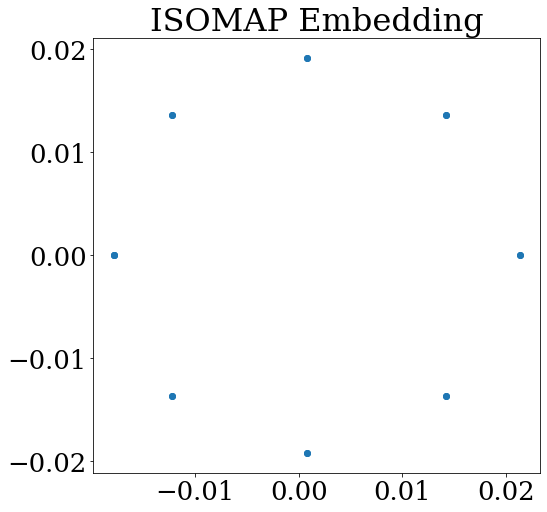

In [114]:
# Wassmap Embedding
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax1 = plt.subplots()
scatter_x = WassEmbedding[:,0]
scatter_y = WassEmbedding[:,1]
ax1.scatter(scatter_x,scatter_y,s=50)
ax1.set_title('Wassmap Embedding',pad=20)
plt.show()

# ISOMAP Embedding
temp = np.reshape(rot_images_vox.T,[rot_images_vox.shape[-1],rot_images_vox.shape[0]**2])
rot_embedded_isomap = man.Isomap(n_neighbors=5,n_components=4,metric='euclidean',).fit_transform(temp)
fig, ax = plt.subplots()
scatter_x = rot_embedded_isomap[:,0]
scatter_y = rot_embedded_isomap[:,1]
ax.scatter(scatter_x, scatter_y)
ax.set_title("ISOMAP Embedding")
plt.show()

## Experiment 5: Rotation of uncentered ellipse about the origin
Here we generate the indicator of an ellipse centered at $(3,2)$ and rotated about the origin at uiformly spaced angles on the circle. The figures below correspond to Figure 5 in the paper.

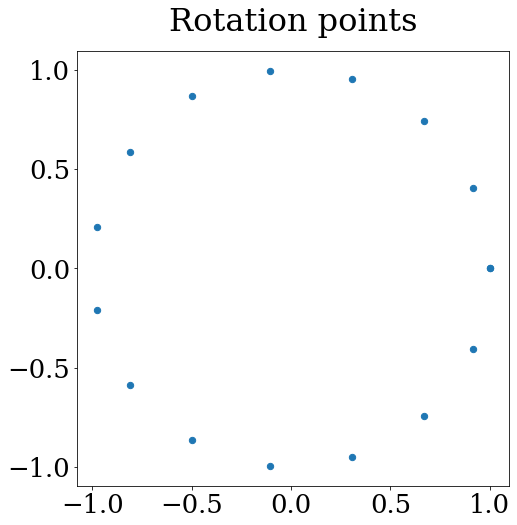

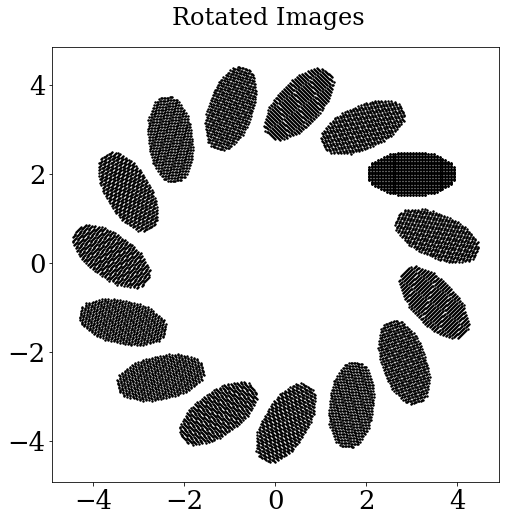

In [135]:
##Ellipse rotation test 2::Image generation and setup:: Ellipse centered at (3,2) rotated about the origin

# Generate ellipse
num_samplepoints = 32
ellipse = generate_ellipse([3,2], 1, .5, samples = num_samplepoints)

# Generate translation set
num_rotations = 16
theta = np.linspace(0,2*np.pi,num=num_rotations)
x = np.cos(theta)
y = np.sin(theta)
rotates = np.zeros((num_rotations,2))
for i in range(len(x)):
    rotates[i,0] = x[i]
    rotates[i,1] = y[i]
    

# Plot the rotation set 
fig1,ax1 = plt.subplots()
ax1.scatter(rotates[:,0],rotates[:,1],s=40)
ax1.set_aspect('equal')
ax1.set_title('Rotation points', pad=20)
plt.show()

# Generate translation images and image tensor
rot_images = np.zeros((ellipse.shape[0],ellipse.shape[1],num_rotations))
for i in range(num_rotations):
    rot_images[:,:,i] = rotation(ellipse,theta[i])

fig2,ax2 = plt.subplots()
for i in range(num_rotations): 
        xxplt = rot_images[:,0,i]
        yyplt = rot_images[:,1,i]
        ax2.scatter(xxplt,yyplt,s=2,c='#000000')
fig2.suptitle("Rotated Images", fontsize=24,y=.95)
plt.show()

rot_images = []
for i in range(rotates.shape[0]):
    img = np.concatenate((rotation(ellipse,theta[i]),np.ones((ellipse.shape[0],1))/ellipse.shape[0]),axis=1)
    rot_images.append(img)

# Generate voxel images (for ISOMAP)
nvox = 128
nxg = nvox
nyg = nvox

xg = np.linspace(-5,5,nxg)
yg = np.linspace(-5,5,nyg)
xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
grid = np.stack((xxg,yyg))
rot_images_vox = np.zeros((nvox,nvox,len(rot_images)))
for i in range(len(rot_images)):
    pc = rot_images[i]
    rot_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)

Computed Wasserstein distance matrix (N = 36) in 9.5505 seconds


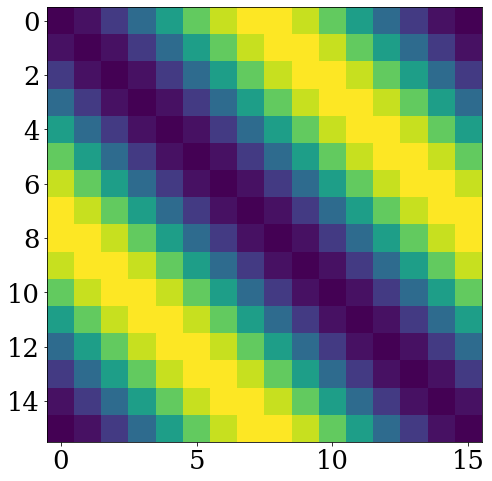

In [136]:
## Ellipse rotation test :: Compute Wasserstein square distance matrix
tic = time.perf_counter()
Wass_distance = Wasserstein_Matrix(rot_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

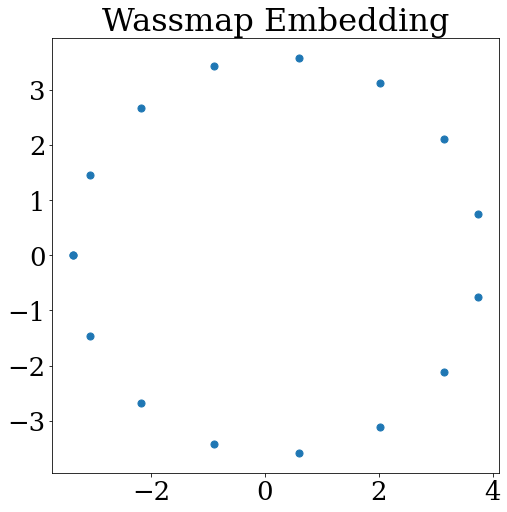

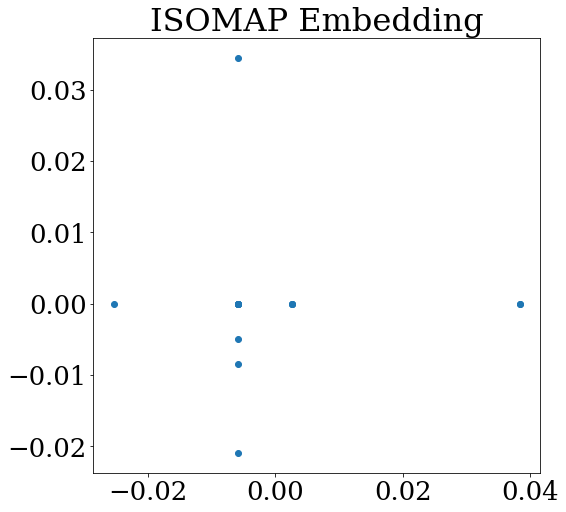

In [147]:
# Wassmap Embedding
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax1 = plt.subplots()
scatter_x = WassEmbedding[:,0]
scatter_y = WassEmbedding[:,1]
ax1.scatter(scatter_x,scatter_y,s=50)
ax1.set_title('Wassmap Embedding')
plt.show()


# ISOMAP Embedding
# Note this embedding is incoherent since all pairwise distance are the same
temp = np.reshape(rot_images_vox.T,[rot_images_vox.shape[-1],rot_images_vox.shape[0]**2])
rot_embedded_isomap = man.Isomap(n_neighbors=4,n_components=2,metric='euclidean',).fit_transform(temp)
fig, ax = plt.subplots()
scatter_x = rot_embedded_isomap[:,0]
scatter_y = rot_embedded_isomap[:,1]
ax.scatter(scatter_x, scatter_y)
ax.set_title("ISOMAP Embedding")
plt.show()

# <center>MNIST Experiments</center>

Here we run the experiments on MNIST, which we obtain from keras

11490434/11490434 [==============================] - 1s 0us/step


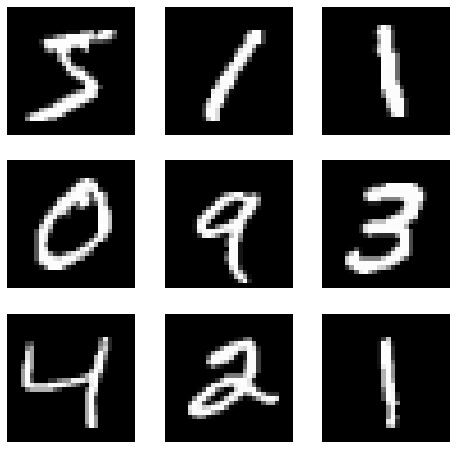

In [148]:
# Import MNIST and plot sample images
from keras.datasets import mnist
(train_X,train_y), (test_X,test_y) = mnist.load_data()
fig,plts = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        plts[i,j].imshow(train_X[i + 3*j], cmap=plt.get_cmap('gray'))
        plts[i,j].axis('off')

In [149]:
# Extract different number classes for futher experiments
zeros = train_X[train_y==0]
ones = train_X[train_y==1]
twos = train_X[train_y==2]
threes = train_X[train_y==3]
fours = train_X[train_y==4]
fives = train_X[train_y==5]
sixes = train_X[train_y==6]
sevens = train_X[train_y==7]
eights = train_X[train_y==8]
nines = train_X[train_y==9]

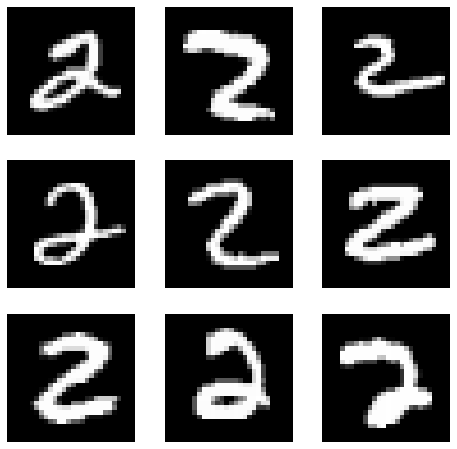

In [150]:
# Plot some 2s for illustration
fig,plts = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        plts[i,j].imshow(twos[i + 3*j], cmap=plt.get_cmap('gray'))
        plts[i,j].axis('off')

grid shape (2, 28, 28)


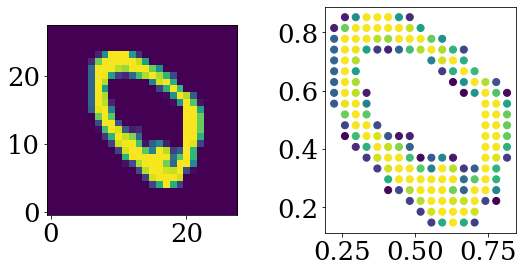

In [151]:
## Test creating pointclouds from MNIST zeros
nxg = 28
nyg = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
print("grid shape",grid.shape)
voxarray = zeros[0,:,:]
X = vox_to_pointcloud(voxarray,grid)

# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)

In [152]:
## Create pointcloud tensor from MNIST zero images

nxg = 28
nxy = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))

# This creates a list of ndarrays, each element of which is a pointcloud representation of an MNIST 0
zeros_pointcloud = list()
for i in range(zeros.shape[0]):
    zeros_pointcloud.append(vox_to_pointcloud(zeros[i,:,:],grid))


## Create pointcloud tensor from MNIST one images
nxg = 28
nxy = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))

# This creates a list of ndarrays, each element of which is a pointcloud representation of an MNIST 1
ones_pointcloud = list()
for i in range(ones.shape[0]):
    ones_pointcloud.append(vox_to_pointcloud(ones[i,:,:],grid))

## MNIST Experiment 1: Separating 0s and 1s
Here we randomly sample some 0s and 1s from MNIST and embed them using Wassmap and ISOMAP. For varying parameters, ISOMAP yields quite different performance. This experiment corresponds to Figure 8 in the paper.

Computed Wasserstein distance matrix (N = 36) in 22.7780 seconds


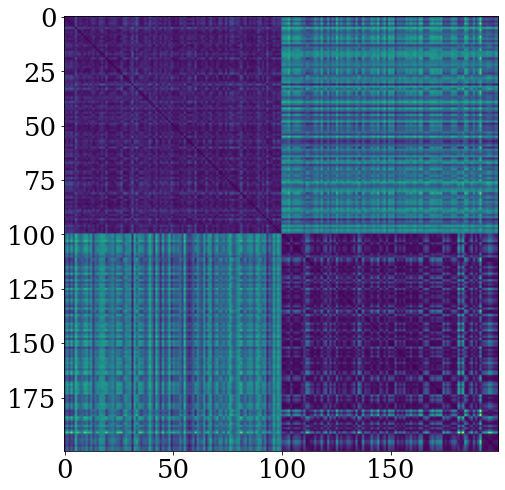

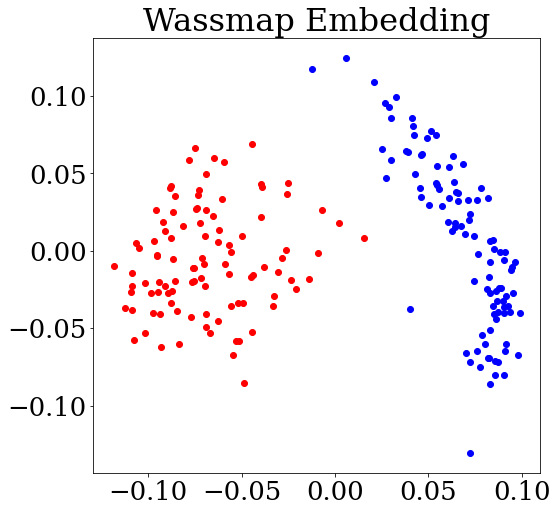

In [153]:
random_zeros = np.random.choice(range(len(zeros_pointcloud)),size=100,replace=False)
random_ones = np.random.choice(range(len(ones_pointcloud)),size=100,replace=False)

tic = time.perf_counter()
# Note the index trick for constructing the list of randomized zeros
dist = []
label=[]

for i in random_zeros:
    dist.append(zeros_pointcloud[i])
for i in random_ones:
    dist.append(ones_pointcloud[i])
Wass_distance = Wasserstein_Matrix(dist,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

# Compute and display Wassmap embedding 
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax = plt.subplots()
num_zeros = len(random_zeros)
num_ones = len(random_ones)
#num_twos = len(random_twos)
ax.scatter(WassEmbedding[range(num_zeros),0],WassEmbedding[range(num_zeros),1],c='r')
ax.scatter(WassEmbedding[range(num_zeros,num_zeros+num_ones),0],WassEmbedding[range(num_zeros,num_zeros+num_ones),1],c='b')
#ax.scatter(WassEmbedding[range(num_zeros+num_ones,num_zeros+num_ones+num_twos),0],WassEmbedding[range(num_zeros+num_ones,num_zeros+num_ones+num_twos),1],c='k')
# ax.scatter(WassEmbedding[range(len(random_ones)),0],WassEmbedding[range(len(random_ones)),1],c='r')
# ax.scatter(WassEmbedding[range(len(random_ones),len(random_ones)+len(random_zeros)),0],WassEmbedding[range(len(random_ones),len(random_ones)+len(random_zeros)),1],c='b')
ax.set_title("Wassmap Embedding")
plt.show()

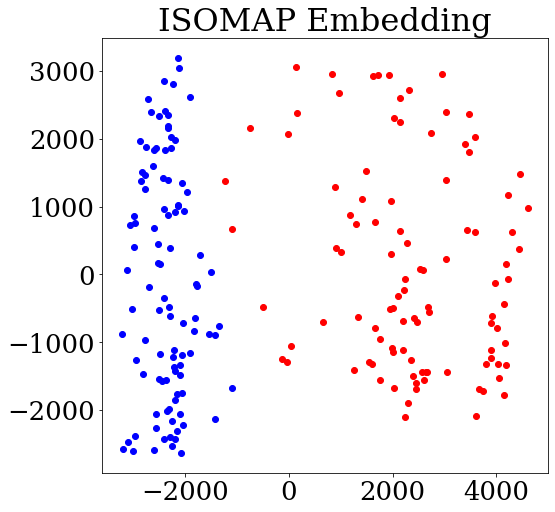

In [180]:
# ISOMAP Embedding
zeros_test = zeros[random_zeros,:,:]
ones_test = ones[random_ones,:,:]
joint = np.concatenate((zeros_test,ones_test)).T

num_zeros=len(random_zeros)
num_ones=len(random_ones)

## Note that changing n_neighbors will greatly change the flavor of the ISOMAP embedding
## In the paper we used varying epsilon (radius parameter in man.Isomap) but Isomap will give warnings
## because the resulting graph is disconnected for too small a choice of radius. Thus for better stability,
## here we utilize the n_neighbors parameter (e.g., below we form the 20-NN graph prior to computing geodesics)
temp = np.reshape(joint.T,[joint.shape[-1],joint.shape[0]**2])
mnist_embedded_isomap = man.Isomap(n_neighbors=20,n_components=2,metric='euclidean',).fit_transform(temp)
fig, ax = plt.subplots()
ax.scatter(mnist_embedded_isomap[range(num_zeros),0], mnist_embedded_isomap[range(num_zeros),1],c='r')
ax.scatter(mnist_embedded_isomap[range(num_zeros,num_zeros+num_ones),0], mnist_embedded_isomap[range(num_zeros,num_zeros+num_ones),1],c='b')
ax.set_title("ISOMAP Embedding")
plt.show()